# Data preparing

This dataset is about a skin canncer classification task. It comes from Kaggle Datasets https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000. 

The dataset (6GB) contains 10015 images and 1 ground truth response CSV file. 

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
- Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
- basal cell carcinoma (bcc)
- benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
- dermatofibroma (df)
- melanoma (mel)
- melanocytic nevi (nv)
- vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

For preparing the dataset, split them, 60% goes to training set, 20% goes to validating set and the rest goes to the testing set.

For passing data to dataloader easily, I moved X_train into dataset/train, X_val to dataset/val and X_test to dataset/test, and for each class, make a folder name with class name and store the corresponding images. Just like the figure shows below.

<img src="https://i.imgur.com/VfVyZsx.png" title="source: imgur.com" width="40%"/>

# Dataset & DataLoader

In [ ]:
!pip install -q transformers datasets

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive/")

In [ ]:
cd gdrive/MyDrive/lsml2_final_project/

In [ ]:
#! unzip HAM10000_dataset.zip

In [ ]:
import random
import numpy as np
import torch

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
from datasets import load_dataset

data_files = {'train': ['HAM10000_dataset/Train/**'], 
              'val': ['HAM10000_dataset/Val/**'],
              'test': ['HAM10000_dataset/Test/**']}

dataset = load_dataset("imagefolder", data_files=data_files)

Resolving data files:   0%|          | 0/6009 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2003 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2003 [00:00<?, ?it/s]

Using custom data configuration default-563d5fcd184e9e93
Reusing dataset imagefolder (C:\Users\ngchi\.cache\huggingface\datasets\imagefolder\default-563d5fcd184e9e93\0.0.0\48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
labels = dataset['train'].features['label'].names
print(len(labels))
labels

7


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
len(dataset['train']), len(dataset['val']), len(dataset['test'])

(6009, 2003, 2003)

In [ ]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)
print(label2id)

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Data distribution

We can find that this is an imbalance dataset, so I will use F1-score as the main metric to evulate the model performance. And for the loss function, I will calculate the weights of difference classes, and use weighted loss function.

In [ ]:
import pandas as pd

df = pd.read_csv('HAM10000_metadata.csv')
print(df.shape)
df.head()

(10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


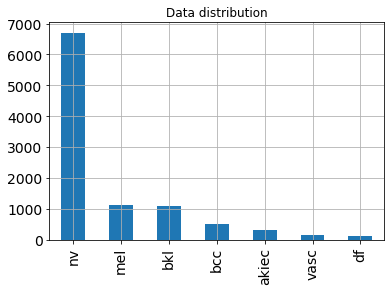

In [ ]:
import matplotlib.pyplot as plt

df['dx'].value_counts().plot.bar(fontsize=14)
plt.grid()
plt.title('Data distribution')
plt.show()

## Visualize data

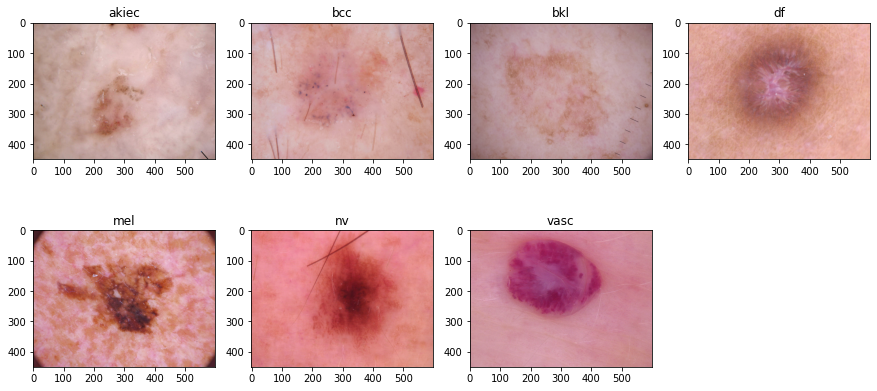

In [ ]:
examples = dataset["train"][[0, 194, 497, 1138, 1199, 1858, 5911]]

plt.figure(figsize=(15, 7))
for i, img in enumerate(examples["image"]):
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(id2label[examples['label'][i]])

# Data Augmentation

In this part:
- resize image to 224 x 224
- Random Horizontal Flip
- Normalize the data with mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]

In [ ]:
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor

def train_transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
    return examples

normalize = Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

transform = Compose(
    [
     RandomResizedCrop(224),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

processed_dataset = dataset.with_transform(train_transforms)

Parameter 'transform'=<function train_transforms at 0x00000260E46755E8> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


## Visualize process data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'transform')

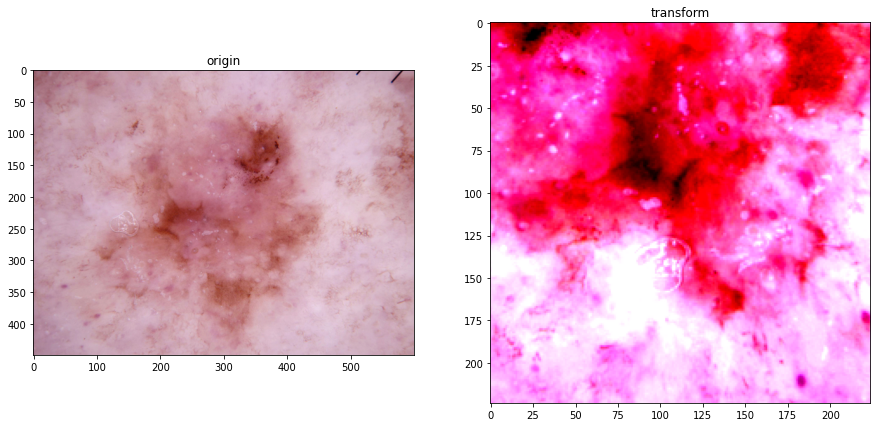

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(dataset['train'][1]['image'])
plt.title('origin')
plt.subplot(1, 2, 2)
plt.imshow(processed_dataset["train"][1]["pixel_values"].permute(2, 1, 0).numpy())
plt.title('transform')

# DataLoader

In [ ]:
from torch.utils.data import DataLoader
import torch 

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

batch_size = 4
dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(processed_dataset["val"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(processed_dataset["test"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

# Modeling

## Custom resnet model

In [ ]:
import torchvision
import torch.nn as nn

class custom_resnet(nn.Module):
    def __init__(self, in_channel=3, out_features=7, backbone="resnet18"):
        super().__init__()
        if backbone == "resnet18":
            self.resnet = torchvision.models.resnet18(pretrained=False)
            self.out = nn.Linear(in_features=512, out_features=out_features, bias=True)
        elif backbone == "resnet50":
            self.resnet = torchvision.models.resnet50(pretrained=False)
            self.out = nn.Linear(in_features=2048, out_features=out_features, bias=True)
        
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4,
            self.resnet.avgpool,
            nn.Flatten(start_dim=1)
        )


    def forward(self, img):
        x = self.backbone(img)
        return self.out(x)


## define training and testing function

In [ ]:
import json

def read_log(path):
    try:
        with open(path, 'r') as f:
            log_file = json.load(f)
        return log_file
    except:
        return {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'loss': []}

In [ ]:
from tqdm.notebook import tqdm
from IPython import display
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np

def model_testing(model, dataloader):
    model.eval() # eval mode
    m = torch.nn.Softmax(dim=1)
    correct = 0
    total = 0
    for idx, batch in enumerate(tqdm(dataloader)):
        batch = {k:v.to(device) for k,v in batch.items()}
        with torch.no_grad():
            logits = model(batch["pixel_values"])
            logits = logits if isinstance(logits, torch.Tensor) else logits['logits']
            prediction = torch.argmax(logits, dim=-1)
            loss = criterion(logits, batch['labels'])

        # metrics
        total += batch["labels"].shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == batch["labels"]).sum().item()
        accuracy = correct/total

        y_true = batch["labels"]
        logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
        predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
        y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))

    y_score = m(logits_).detach().cpu().numpy()
    y_true = y_true_.detach().cpu().numpy()
    y_pred = predicted_.detach().cpu().numpy()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted') # sensitivity
    f1 = 2 * precision * recall / (precision + recall)
    return {'acc': accuracy, 'f1': f1, 'precision': precision, 'recall': recall, 'loss': loss.item()}

In [ ]:
def train_model(model, dataloader, val_dataloader, model_name, criterion, optimizer, num_epochs=15):
    m = torch.nn.Softmax(dim=1)
    print(f"training: {model_name}")
    
    train_log = read_log(f"train_log_{model_name}.json")
    val_log = read_log(f"val_log_{model_name}.json")
    
    start_epoch = len(train_log['acc'])
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f"Epoch: {epoch}/{start_epoch + num_epochs - 1}")
        correct = 0
        total = 0
        model.train()
        for idx, batch in enumerate(tqdm(dataloader)):
            # move batch to GPU
            batch = {k:v.to(device) for k,v in batch.items()}

            optimizer.zero_grad()

            # forward pass
            logits = model(batch["pixel_values"])
            logits = logits if isinstance(logits, torch.Tensor) else logits['logits']
            prediction = torch.argmax(logits, dim=-1)

            loss = criterion(logits, batch['labels'])
            loss.backward()
            optimizer.step()

            # metrics
            total += batch["labels"].shape[0]
            predicted = logits.argmax(-1)
            correct += (predicted == batch["labels"]).sum().item()
            accuracy = correct/total

            y_true = batch["labels"]
            logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
            predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
            y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))

            if idx % 100 == 0:
                print(f"Loss after {idx} steps:", loss.item())
                print(f"Accuracy after {idx} steps:", accuracy)

        y_score = m(logits_).detach().cpu().numpy()
        y_true = y_true_.detach().cpu().numpy()
        y_pred = predicted_.detach().cpu().numpy()
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = 2 * precision * recall / (precision + recall)

        # save the train acc and loss
        train_log['acc'].append(accuracy)
        train_log['precision'].append(precision)
        train_log['recall'].append(recall)
        train_log['f1'].append(f1)
        train_log['loss'].append(loss.item())

        with open(f"train_log_{model_name}.json", "w") as outfile:
            json.dump(train_log, outfile)

        # eval
        model.eval() # eval mode
        print('validating:')
        result_val = model_testing(model, val_dataloader)

        # save the train acc and loss
        val_log['acc'].append(result_val['acc'])
        val_log['precision'].append(result_val['precision'])
        val_log['recall'].append(result_val['recall'])
        val_log['f1'].append(result_val['f1'])
        val_log['loss'].append(result_val['loss'])

        with open(f"val_log_{model_name}.json", "w") as outfile:
            json.dump(val_log, outfile)

        model_path = f"models/{model_name}_{epoch}.pth"
        torch.save(model.state_dict(), model_path)

        # plot
        display.clear_output()
        plt.figure(figsize=(20, 10))
        for i, key in enumerate(train_log.keys()):
            plt.subplot(3, 2, i+1)
            plt.plot(train_log[key], 'x-', label=f'train_{key}')
            plt.plot(val_log[key], 'x-', label=f'val_{key}')
            plt.grid()
            plt.legend()
        plt.show()

## Calculate the class weights

In [ ]:
from collections import Counter

y = dataset['train']['label']
weigths = Counter(y)
total = len(y)
max_class_id = label2id['nv']
max_class_freq = weigths[max_class_id]/total
class_weights = torch.tensor([1/(weigths[i]/total/max_class_freq) for i in range(7)])

In [ ]:
class_weights

tensor([20.8918, 13.3762,  6.3229, 66.4426,  6.1502,  1.0000, 41.3571])

## Training Resnet18 from scratch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

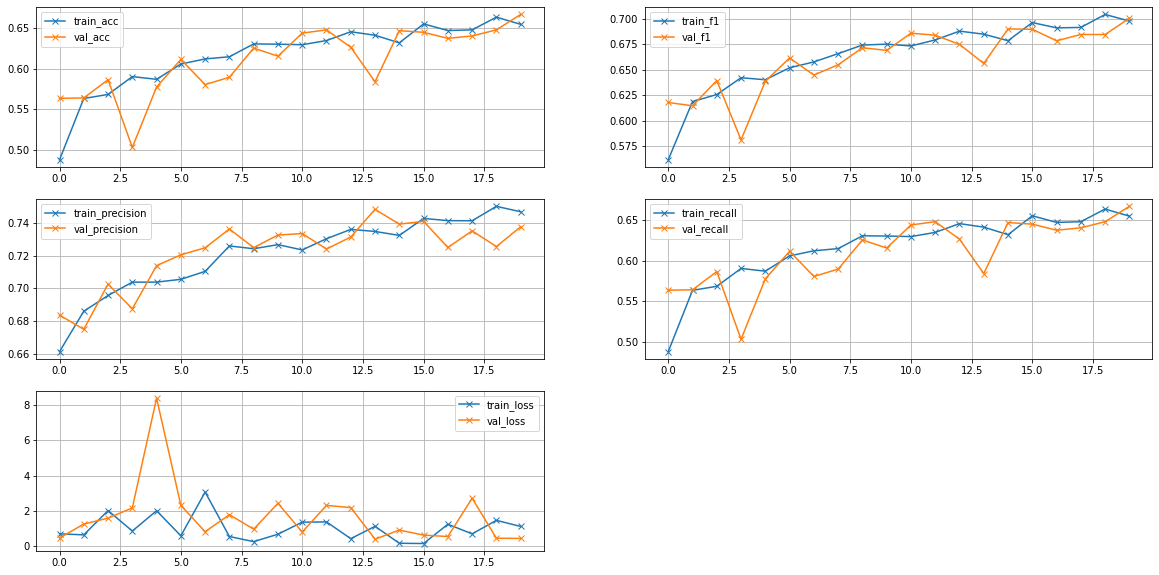

In [ ]:
model = custom_resnet(backbone="resnet18")
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

train_model(
    model=model,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    model_name="resnet18_pretrain",
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20
)

## Training Resnet50 from scratch

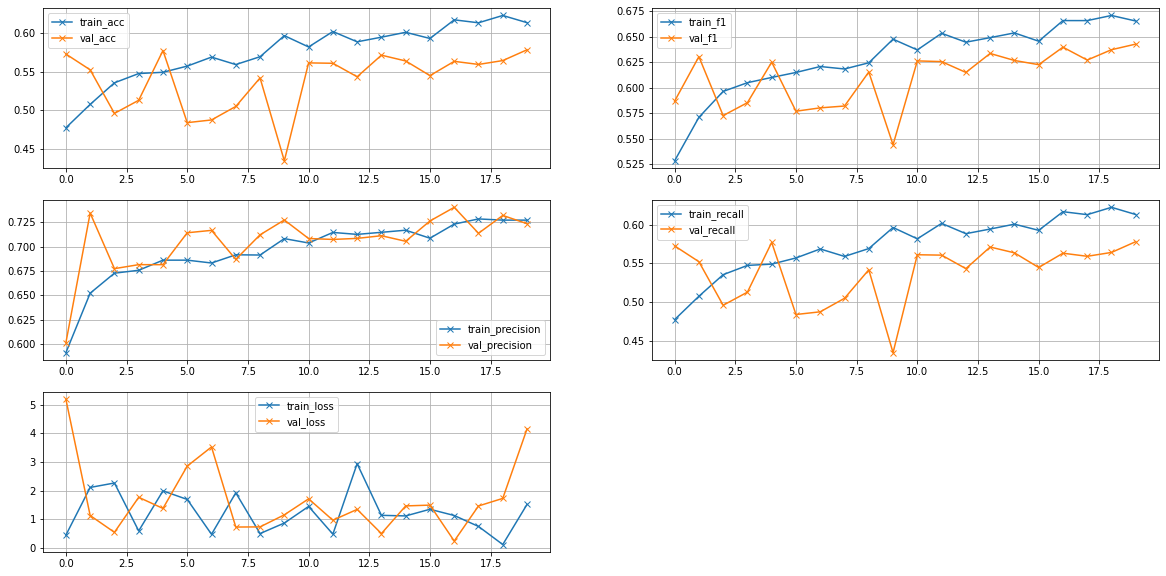

In [ ]:
model = custom_resnet(backbone="resnet50")
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

train_model(
    model=model,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    model_name="resnet50",
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20
)

# Testing Set

In [ ]:
resnet18_model = custom_resnet(backbone="resnet18")
resnet18_model.load_state_dict(torch.load("models/resnet18_19.pth"))

<All keys matched successfully>

In [ ]:
resnet18_model.to(device)
test_log_resnet18 = model_testing(resnet18_model, test_dataloader)

  0%|          | 0/501 [00:00<?, ?it/s]

In [ ]:
print("resnet18 preform on testing set")
test_log_resnet18

resnet18 preform on testing set


{'acc': 0.6505242136794808,
 'f1': 0.6907409100893335,
 'precision': 0.7362578285163032,
 'recall': 0.6505242136794808,
 'loss': 0.379764199256897}

In [ ]:
resnet50_model = custom_resnet(backbone="resnet50")
resnet50_model.load_state_dict(torch.load("models/resnet50_16.pth"))

<All keys matched successfully>

In [ ]:
resnet50_model.to(device)
test_log_resnet50 = model_testing(resnet50_model, test_dataloader)

  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
print("resnet50 preform on testing set")
test_log_resnet50

resnet50 preform on testing set


{'acc': 0.5496754867698452,
 'f1': 0.6269983439361672,
 'precision': 0.7296362893042073,
 'recall': 0.5496754867698452,
 'loss': 3.1232995986938477}

# Brief Summary

We can find that the performance (f1-score) of resnet18 is better than resnet50. Because in this project, I didn't use pretrain resnet, and we can find that we only have around 6000 images for training, besides, the dataset is very imbalance. Hence, it might not have enough images to update the weights in the resnet50. So in this case, a small model might performs better.

# transfer learning with ConvNeXT large model

In this part, I select a pre-trained convnext large model to transfer learning, and then, and since this model a too big, around 766Mb, I apply knowledge distillation and use this model as `teacher` to teach our pervious resnet18 model

In [ ]:
from transformers import AutoModelForImageClassification


model_name = "facebook/convnext-large-224"
model = AutoModelForImageClassification.from_pretrained(model_name,
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-large-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([7, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

cuda


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

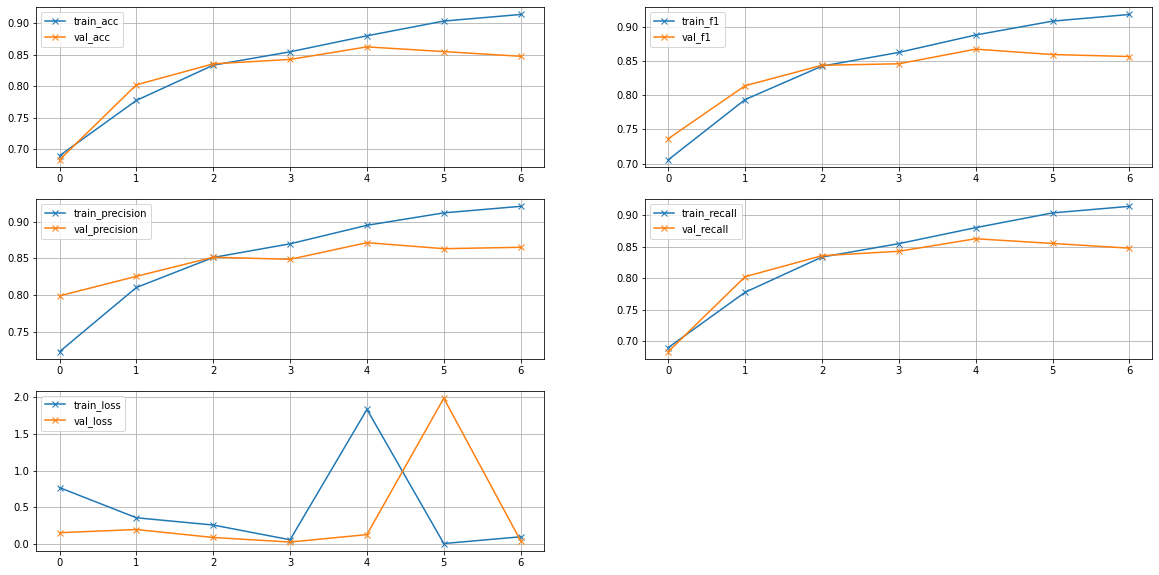

In [ ]:
train_model(
    model=model,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    model_name="convnext_large",
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=7
)

I train it 7 epochs, and at the 4 epoch, it has the best f1 score on validation set, around 85%, so I stop at this epoch.

In [ ]:
# re-load this model
model.load_state_dict(torch.load("models/convnext_large_4.pth"))

<All keys matched successfully>

## Testing set on convnext

In [ ]:
test_log_convnext = model_testing(model, test_dataloader)
test_log_convnext

  0%|          | 0/501 [00:00<?, ?it/s]

{'acc': 0.8412381427858213,
 'f1': 0.8489872670209442,
 'precision': 0.8568804817601406,
 'recall': 0.8412381427858213,
 'loss': 1.09429931640625}

# Knowledge distillation

distill the knowledge from the big model into smaller model.

In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable


def distill(teacher_model, student_model, train_loader, val_dataloader, model_name, epoch_number=5, alpha=0.5, temperature=2):
    def error_and_output(var_X_batch, var_y_batch): # create loss function
        # Kullback-Leibler Divergence is used to calc cross-entropy between answers of models
        kldloss = nn.KLDivLoss(reduction='batchmean')  
        # Regular cross-entropy
        celoss = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
        
        # teached model outputs
        teacher_logits = teacher_model(var_X_batch)
        teacher_logits = teacher_logits if isinstance(teacher_logits, torch.Tensor) else teacher_logits['logits']
        # student model outputs
        student_logits = student_model(var_X_batch)
        teacher_logits = student_logits if isinstance(student_logits, torch.Tensor) else student_logits['logits']
        
        # softmax with temperature T for student network
        soft_predictions = F.log_softmax( student_logits / temperature, dim=1 )
        # and for teacher network
        soft_labels = F.softmax( teacher_logits / temperature, dim=1 )
        # distillation loss
        distillation_loss = kldloss(soft_predictions, soft_labels)
        
        # regular loss
        student_loss = celoss(student_logits, var_y_batch)
        
        # sum-up
        return distillation_loss * alpha + student_loss * (1 - alpha), student_logits
    
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)

    student_model.train()
    
    train_log = read_log(f"train_log_{model_name}.json")
    val_log = read_log(f"val_log_{model_name}.json")
    m = torch.nn.Softmax(dim=1)
    
    best_val_f1 = 0
    
    # train goes as usual
    for epoch in range(epoch_number):
        correct = 0
        total = 0
        for idx, batch in enumerate(tqdm(train_loader)):
            X_batch, y_batch = batch['pixel_values'].to(device), batch['labels'].to(device)
            
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            loss, logits = error_and_output(var_X_batch, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(logits.data, 1)[1]
            
            total += y_batch.shape[0]
            correct += (predicted == y_batch).sum().item()
            accuracy = correct/total

            y_true = y_batch
            logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
            predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
            y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))

            if idx and idx % 100 == 0:
                print(f"Loss after {idx} steps:", loss.item())
                print(f"Accuracy after {idx} steps:", accuracy)
                precision_ = precision_score(y_true_.detach().cpu().numpy(), 
                                             predicted_.detach().cpu().numpy(), average='weighted')
                recall_ = recall_score(y_true_.detach().cpu().numpy(), 
                                       predicted_.detach().cpu().numpy(), average='weighted')
                f1_ = 2 * precision_ * recall_ / (precision_ + recall_)
                print(f"f1 after {idx} steps:", f1_)
                
        y_score = m(logits_).detach().cpu().numpy()
        y_true = y_true_.detach().cpu().numpy()
        y_pred = predicted_.detach().cpu().numpy()
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = 2 * precision * recall / (precision + recall)
        
        # save the train acc and loss
        train_log['acc'].append(accuracy)
        train_log['precision'].append(precision)
        train_log['recall'].append(recall)
        train_log['f1'].append(f1)
        train_log['loss'].append(loss.item())

        with open(f"train_log_{model_name}.json", "w") as outfile:
            json.dump(train_log, outfile)

        # eval
        student_model.eval() # eval mode
        print('validating:')
        
        correct = 0
        total = 0
        for idx, batch in enumerate(tqdm(val_dataloader)):
            X_batch, y_batch = batch['pixel_values'].to(device), batch['labels'].to(device)
            
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            with torch.no_grad():
                loss, logits = error_and_output(var_X_batch, var_y_batch)
                
            predicted = torch.max(logits.data, 1)[1]
            
            total += y_batch.shape[0]
            correct += (predicted == y_batch).sum().item()
            accuracy = correct/total

            y_true = y_batch
            logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
            predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
            y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))
        
        y_score = m(logits_).detach().cpu().numpy()
        y_true = y_true_.detach().cpu().numpy()
        y_pred = predicted_.detach().cpu().numpy()
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = 2 * precision * recall / (precision + recall)
        
        # save the train acc and loss
        val_log['acc'].append(accuracy)
        val_log['precision'].append(precision)
        val_log['recall'].append(recall)
        val_log['f1'].append(f1)
        val_log['loss'].append(loss.item())
        

        with open(f"val_log_{model_name}.json", "w") as outfile:
            json.dump(val_log, outfile)
            
        if f1 > best_val_f1:
            model_path = f"models/{model_name}_best.pth"
            torch.save(student_model.state_dict(), model_path)
            best_val_f1 = f1

        # plot
        display.clear_output()
        plt.figure(figsize=(20, 10))
        for i, key in enumerate(train_log.keys()):
            plt.subplot(3, 2, i+1)
            plt.plot(train_log[key], 'x-', label=f'train_{key}')
            plt.plot(val_log[key], 'x-', label=f'val_{key}')
            plt.grid()
            plt.legend()
        plt.show()

## Distill the knowledge from ConvNeXt to Resnet18

In this part, I use grid search to find the best alpha and temperature. 
- alpha list: [0.1, 0.3, 0.5, 0.7, 0.9]
- temperature list: [1, 5, 10, 15, 20]

I will run total 25 experiments.

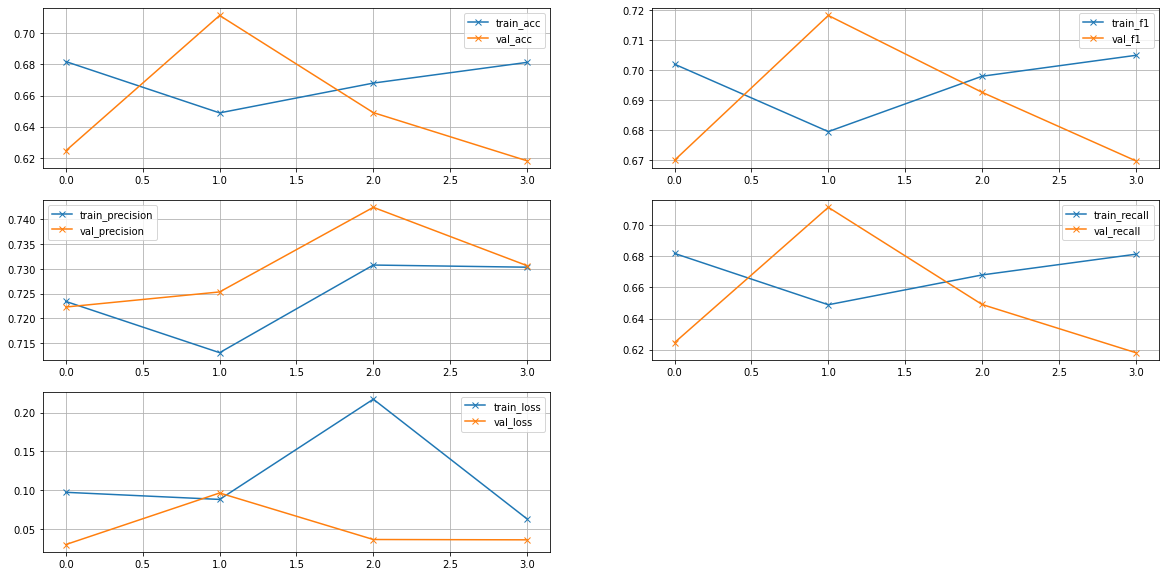

In [ ]:
from itertools import product

experiments = list(product([0.1, 0.3, 0.5, 0.7, 0.9], [1, 5, 10, 15, 20]))

for alpha, temperature in experiments:
    print(f'run on alpha: {alpha}, temperature: {temperature}:')
    
    student_model = custom_resnet(backbone='resnet18')
    student_model.load_state_dict(torch.load("models/resnet18_19.pth"))
    
    model_name = f"distll_resnet_{alpha}_{temperature}"
    val_log = read_log(f"val_log_{model_name}.json")
    
    if not val_log['f1']:
        distill(teacher_model=model.to(device),
                student_model=student_model.to(device), 
                train_loader=dataloader, 
                val_dataloader=val_dataloader, 
                model_name=model_name, 
                epoch_number=4, 
                alpha=alpha,
                temperature=temperature)


# Summary

We can find the best hyperparameters in distillation part is alpha = 0.5 and temperature = 15, the f1 of resnet18 = 73%

In [ ]:
import os

distill_val_f1 = [i.replace('val_log_distll_resnet_', '')[:-5].split('_') +
                   [max(read_log(i)['f1'])] for i in os.listdir('.') if 'val_log_distll_resnet' in i]
distill_val_logs = pd.DataFrame(distill_val_f1, columns=['alpha', 'temperature', 'f1'])

In [ ]:
distill_val_logs.sort_values(by='f1', ascending=ng=False).head()

,alpha,temperature,f1
12,0.5,15,0.729654
22,0.9,15,0.727643
18,0.7,20,0.723446
17,0.7,15,0.721111
20,0.9,1,0.719928


Test the distill resnet18 model again, we can find that the f1 score on testing set is 73.1%, better than the resnet18 training from scratch 69.1%, it almost improves 4%.

Although the performance of distill resnet18 is not as good as the teacher model (f1=84.9%), but if we take the model size into account, the resnet18 only takes 45.8mb, and the convnext takes 766.7mb.

In [ ]:
distill_resnet18_model = custom_resnet(backbone="resnet18")
distill_resnet18_model.load_state_dict(torch.load("models/distll_resnet_0.5_15_best.pth"))

<All keys matched successfully>

In [ ]:
distill_resnet18_model.to(device)
test_log_distill_resnet18 = model_testing(distill_resnet18_model, test_dataloader)

  0%|          | 0/501 [00:00<?, ?it/s]

In [ ]:
test_log_distill_resnet18

{'acc': 0.7309036445332002,
 'f1': 0.7307008478737846,
 'precision': 0.7255711017009783,
 'recall': 0.7359036445332002,
 'loss': 0.45891618728637695}